In [10]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
 
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений

import seaborn as sns #для визуализации
import matplotlib.pyplot as plt #для визуализации
plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
%matplotlib inline

In [19]:
#Функция для визуализации модели
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Glucose изменяется от x1_min = 44 до x2_max = 199, 
    #BMI — от x2_min = 18.2 до x2_max = 67.1
    #Результат работы функции - два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказывает вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линия, где вероятность равна 0.5.
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))

In [11]:
water_data = pd.read_csv('../../data/water_potability.csv')
water_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [12]:
water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')['Trihalomethanes'].transform('median'))

In [13]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']

In [14]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Создаём модель
model_bad = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    class_weight='balanced', #веса классов
    random_state=42 #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model_bad.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model_bad.predict(X_train)
y_valid_pred = model_bad.predict(X_valid)
#Выводим значения метрик для тренировочной выборки
print('Train F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
#Выводим значения метрик для валидационной выборки
print('Valid F1 score: {:.2f}'.format(metrics.f1_score(y_valid, y_valid_pred)))
 
# Train F1 score: 1.00
# Valid F1 score: 0.67

Train F1 score: 1.00
Valid F1 score: 0.67


In [15]:
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model_bad, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.16400909, 0.14800858, 0.16300917, 0.15500879, 0.17600989]),
 'score_time': array([0.00700045, 0.00600028, 0.00600052, 0.00600028, 0.00500035]),
 'test_score': array([0.61445783, 0.68421053, 0.62332696, 0.63276836, 0.70119522]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [16]:
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))
## Train k-fold mean f1: 1.00
## Valid k-fold mean f1: 0.65

Train k-fold mean f1: 1.00
Valid k-fold mean f1: 0.65


### Задание 4.3
Ниже представлен код для генерации задачи классификации и отрисовки диаграммы рассеяния с цветовой группировкой по классам.

Разделите исходный набор данных на тренировочную и валидационную выборки в соотношении 70/30, используя функцию train_test_split(). В качестве значения параметра random_state возьмите число 42.

Обучите модель дерева решений с глубиной 10 (остальные параметры оставьте по умолчанию) для решения задачи классификации на тренировочной выборке. Сделайте предсказания для тренировочной и валидационной выборок и рассчитайте метрику accuracy.

В качестве ответа укажите значение метрики accuracy на тренировочной и валидационной выборках. Ответ округлите до двух знаков после точки-разделителя.

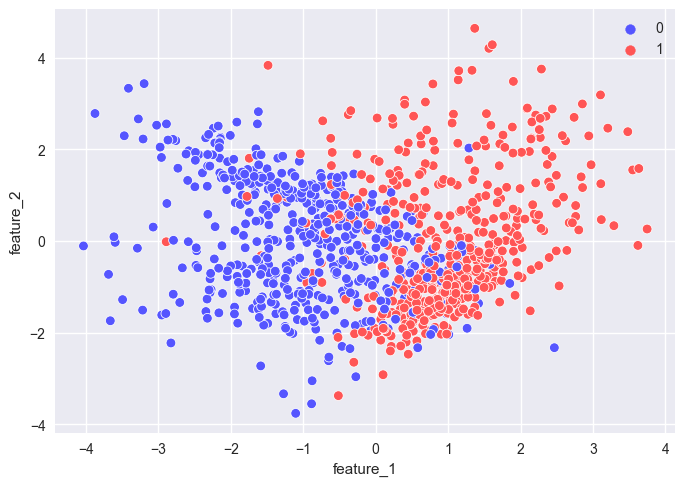

In [17]:
from sklearn import datasets
X_2, y_2 = datasets.make_classification(
    n_samples=1000, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    n_clusters_per_class=2, #количество кластеров внутри класса
    random_state=1 #генератор случайных чисел
)
X_2 = pd.DataFrame(X_2, columns=['feature_1', 'feature_2'])
y_2 = pd.Series(y_2)
sns.scatterplot(x=X_2['feature_1'], y=X_2['feature_2'], hue=y_2, palette='seismic');

In [18]:
# 1
X_train_2, X_valid_2, y_train_2, y_valid_2 = model_selection.train_test_split(X_2, y_2, stratify=y_2, test_size=0.3, random_state=42)
# 2
#Создаём модель
model_bad_2 = tree.DecisionTreeClassifier(
    # criterion='entropy', #критерий информативности
    max_depth=10 #максимальная глубина
    # class_weight='balanced', #веса классов
    # random_state=42 #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model_bad_2.fit(X_train_2, y_train_2)
#Делаем предсказание для каждой из выборок
y_train_pred = model_bad_2.predict(X_train_2)
y_valid_pred = model_bad_2.predict(X_valid_2)
#Выводим значения метрик для тренировочной выборки
print('Train accuracy score: {:.2f}'.format(metrics.accuracy_score(y_train_2, y_train_pred)))
#Выводим значения метрик для валидационной выборки
print('Valid accuracy score: {:.2f}'.format(metrics.accuracy_score(y_valid_2, y_valid_pred)))

Train accuracy score: 0.98
Valid accuracy score: 0.82


### Задание 4.4 (на самопроверку)
Воспользуйтесь функцией plot_probabilities_2d() и постройте разделяющую поверхность обученного дерева решений.

Примечание. Код функции plot_probabilities_2d() вы можете найти в задании 3.6.

Передайте в её аргументы матрицу наблюдений X, вектор ответов y и обученное в задании 4.3 дерево решений.

Является ли ваша модель переобученной?

c:\Users\Temnykov\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


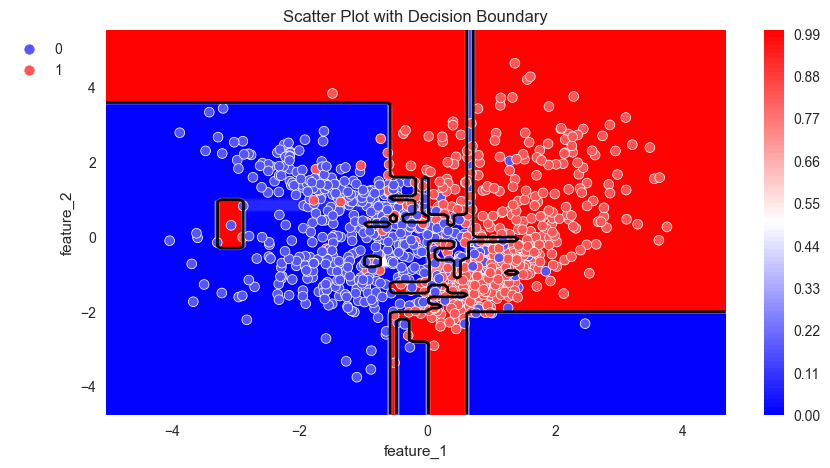

In [20]:
plot_probabilities_2d(X_2, y_2, model_bad_2)

In [21]:
print('Current depth:', model_bad.get_depth())
## Current depth: 27

Current depth: 27


In [28]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #ограничиваем глубину дерева
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))


## Train k-fold mean f1: 0.75
## Valid k-fold mean f1: 0.66

Train k-fold mean f1: 0.75
Valid k-fold mean f1: 0.66


In [32]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #ограничиваем глубину дерева
    min_samples_leaf=5, #увеличиваем количество объектов в листе
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))
## Train k-fold mean f1: 0.74
## Valid k-fold mean f1: 0.66

Train k-fold mean f1: 0.74
Valid k-fold mean f1: 0.66


### Задание 4.6
Для выполнения этого задания используйте сгенерированные тренировочную и валидационную выборки из задания 4.3.

Обучите модель дерева решений с глубиной 3 (остальные параметры оставьте по умолчанию) для решения задачи классификации на тренировочной выборке.

Сделайте предсказания для тренировочной и валидационной выборок и рассчитайте метрику accuracy.

В качестве ответа укажите значение метрики accuracy на тренировочной и валидационной выборках. Ответ округлите до двух знаков после точки-разделителя.

In [33]:
#Создаём модель
model_bad_2 = tree.DecisionTreeClassifier(
    # criterion='entropy', #критерий информативности
    max_depth=3 #максимальная глубина
    # class_weight='balanced', #веса классов
    # random_state=42 #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model_bad_2.fit(X_train_2, y_train_2)
#Делаем предсказание для каждой из выборок
y_train_pred = model_bad_2.predict(X_train_2)
y_valid_pred = model_bad_2.predict(X_valid_2)
#Выводим значения метрик для тренировочной выборки
print('Train accuracy score: {:.2f}'.format(metrics.accuracy_score(y_train_2, y_train_pred)))
#Выводим значения метрик для валидационной выборки
print('Valid accuracy score: {:.2f}'.format(metrics.accuracy_score(y_valid_2, y_valid_pred)))

Train accuracy score: 0.88
Valid accuracy score: 0.85


c:\Users\Temnykov\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


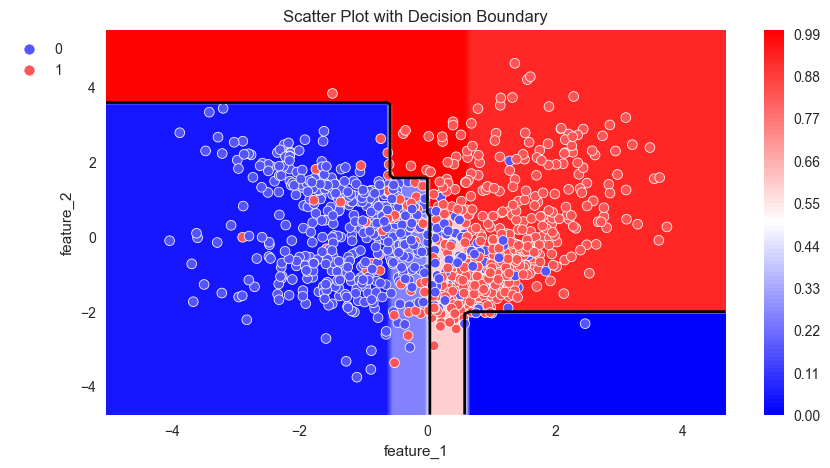

In [34]:
plot_probabilities_2d(X_2, y_2, model_bad_2)